# LAB | Audio Classification CNN

## Introduction
This notebook guides you through audio classification using a CNN model on the Kaggle audio dataset. You will:
- Load and explore the dataset
- Apply various preprocessing methods (MFCC, Mel spectrogram, Chromagram)
- Build and train a CNN classifier on these features
- Experiment with preprocessing parameters to improve results

## Step 1: Setup & Dataset Loading

In [1]:
# !pip install librosa 

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-12-10 15:22:07.118507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 15:22:07.165661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 15:22:08.343241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("warcoder/cats-vs-dogs-vs-birds-audio-classification")

print("Path to dataset files:", path)

/home/leonbts/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 13.2M/13.2M [00:00<00:00, 17.1MB/s]

Extracting files...


Path to dataset files: /home/leonbts/.cache/kagglehub/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification/versions/1


In [4]:
files_in_dir = os.listdir(path)
print(files_in_dir)

['Animals']


In [5]:
#TODO: create a dataframe

audio_paths = []
labels = []

# Walk through the dataset folder and collect file paths + labels (folder names)
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith((".wav", ".mp3", ".flac", ".ogg")):
            full_path = os.path.join(root, file)
            label = os.path.basename(root)   # assume folder name = class label
            audio_paths.append(full_path)
            labels.append(label)

df = pd.DataFrame({"filepath": audio_paths, "label": labels})
print(df.head())

# encode labels as integers (needed later)
df["label_idx"], label_names = pd.factorize(df["label"])
num_classes = len(label_names)
print("Classes:", list(label_names))

                                            filepath label
0  /home/leonbts/.cache/kagglehub/datasets/warcod...   cat
1  /home/leonbts/.cache/kagglehub/datasets/warcod...   cat
2  /home/leonbts/.cache/kagglehub/datasets/warcod...   cat
3  /home/leonbts/.cache/kagglehub/datasets/warcod...   cat
4  /home/leonbts/.cache/kagglehub/datasets/warcod...   cat
Classes: ['cat', 'dog', 'bird']


## Step 2: Audio Preprocessing Functions

Define functions for feature extraction you will experiment with:

- MFCC
- Spectrogram
- Chromogram

In [6]:
##TODO: Your_Code_Here

def extract_mfcc(file_path, n_mfcc=40, max_len=174):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # pad or truncate to fixed length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


def extract_melspec(file_path, n_mels=64, max_len=174):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    if S_db.shape[1] < max_len:
        pad_width = max_len - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode="constant")
    else:
        S_db = S_db[:, :max_len]

    return S_db


def extract_chroma(file_path, n_chroma=12, max_len=174):
    y, sr = librosa.load(file_path, sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)

    if chroma.shape[1] < max_len:
        pad_width = max_len - chroma.shape[1]
        chroma = np.pad(chroma, ((0, 0), (0, pad_width)), mode="constant")
    else:
        chroma = chroma[:, :max_len]

    return chroma


def feature_extractor(file_path, feature_type="mfcc", max_len=174):
    if feature_type == "mfcc":
        return extract_mfcc(file_path, max_len=max_len)
    elif feature_type == "melspec":
        return extract_melspec(file_path, max_len=max_len)
    elif feature_type == "chroma":
        return extract_chroma(file_path, max_len=max_len)
    else:
        raise ValueError(f"Unknown feature_type: {feature_type}")

## Step 3: Visualize Audio Features

Visualize extracted features for a sample audio file:

Sample file: /home/leonbts/.cache/kagglehub/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification/versions/1/Animals/cat/784e281a_nohash_0.wav
Label: cat


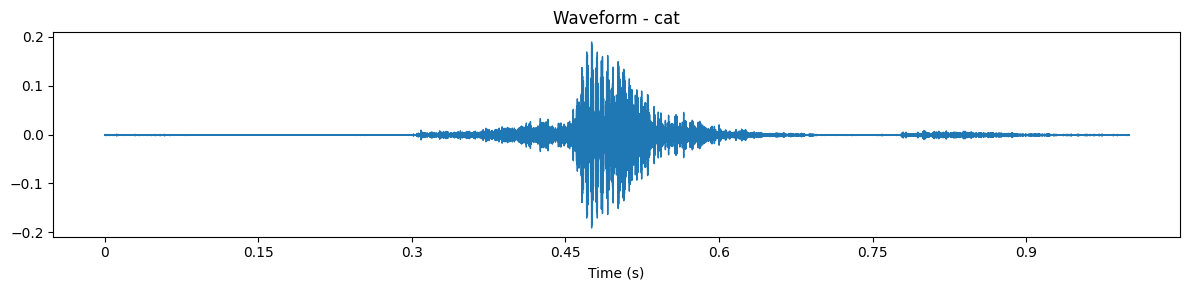

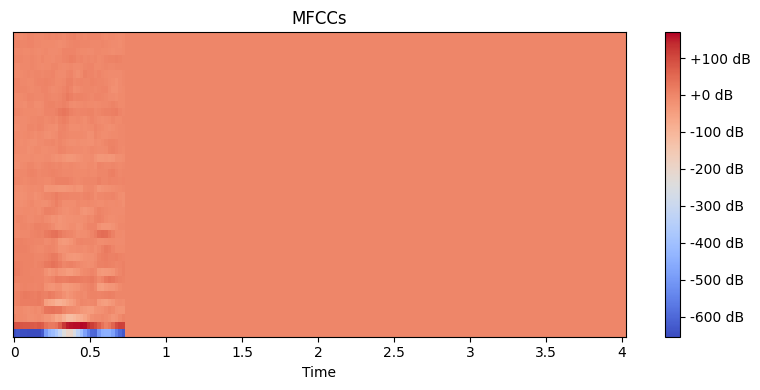

In [7]:
##TODO: Your_Code_Here

# pick one example
sample_path = df["filepath"].iloc[0]
sample_label = df["label"].iloc[0]
print("Sample file:", sample_path)
print("Label:", sample_label)

# waveform
y, sr = librosa.load(sample_path, sr=None)
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - {sample_label}")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

# MFCCs
mfcc = extract_mfcc(sample_path)
plt.figure(figsize=(8, 4))
librosa.display.specshow(mfcc, x_axis="time")
plt.colorbar(format="%+2.0f dB")
plt.title("MFCCs")
plt.tight_layout()
plt.show()

## Step 4: Prepare Data for CNN

Extract features for all files and prepare train/test sets:

In [8]:
##TODO: Your_Code_Here

feature_type = "mfcc"  # change to "melspec" or "chroma" to experiment
max_len = 174          # must match what you used in the extractor

X_list = []

for fp in df["filepath"]:
    feat = feature_extractor(fp, feature_type=feature_type, max_len=max_len)
    X_list.append(feat)

X = np.array(X_list)

# add channel dimension: (samples, height, width, channels)
X = X[..., np.newaxis]

y = df["label_idx"].values
y_cat = to_categorical(y, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y
)

input_shape = X_train.shape[1:]
print("Input shape:", input_shape)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Input shape: (40, 174, 1)
Train size: 488 Test size: 122


## Step 5: Define CNN Model

In [9]:
##TODO: Your_Code_Here

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

/home/leonbts/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1765376545.815487    9448 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765376545.822774    9448 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 172, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 42, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,752,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,771,843 (10.57 MB)

 Trainable params: 2,771,843 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train and Evaluate

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.3487 - loss: 8.8987 - val_accuracy: 0.4082 - val_loss: 1.1052
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4026 - loss: 1.2632 - val_accuracy: 0.3878 - val_loss: 1.0892
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4359 - loss: 1.0771 - val_accuracy: 0.4592 - val_loss: 1.0831
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4846 - loss: 1.0438 - val_accuracy: 0.5510 - val_loss: 1.0395
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5462 - loss: 0.9699 - val_accuracy: 0.5714 - val_loss: 0.9116
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5436 - loss: 0.8846 - val_accuracy: 0.7041 - val_loss: 0.7681
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6077 - loss: 0.7720 - val_accuracy: 0.6837 - val_loss: 0.7859
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s -5633571us/step - accuracy: 0.6359 - loss: 0.7724 - val_accuracy: 0.74

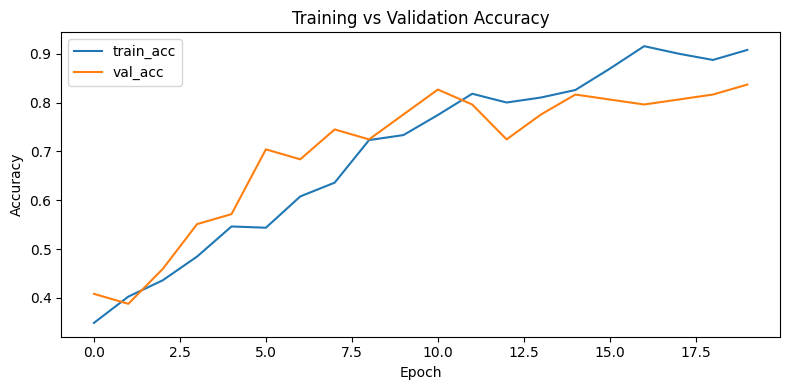

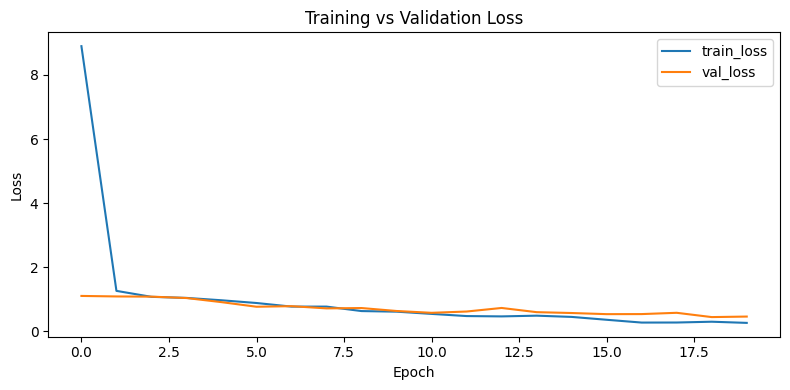

In [10]:
##TODO: Your_Code_Here

epochs = 20
batch_size = 32

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

## Step 7: Experimentation

- Try using Mel Spectrogram and Chromagram as features instead of MFCC by changing the `feature_extractor` function in the data preparation.
- Modify parameters like `n_mfcc`, `n_mels`, `max_len`.
- Tune CNN architecture (add layers, change filters).
- Compare results and report observations.
